In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt

# Loading and splitting data

In [2]:
data_path = './Data/Spooky/train.csv'
df = pd.read_csv(data_path)
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [19]:
df['s'] = df.text.apply(lambda x: len(x.split()))
df.drop(df[df['s'] > 510].index, inplace=True)

In [67]:
Y = df.author
X = df.text

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=2)

In [5]:
x_train

10773    Here, take it back, and give me a glass of bra...
16914    Are there other rudimental thinking beings tha...
15291    We sat in his library, and he spoke of the old...
13339    He raised his eyes from the ground, but still ...
1037              "You may have heard of one Captain Kidd.
                               ...                        
1099     In the multiform of the tree, and in the multi...
18900    The distance of its bottom from the deck overh...
11799    I had not despaired, nor had I yet conceived t...
6637     On the morning of September th Professor Rice ...
2575     It is merely a very long rope which is suffere...
Name: text, Length: 15661, dtype: object

In [ ]:
def encode(x):
    if x == "EAP":
        return 0
    elif x == "HPL":
        return 1
    else:
        return 2

y_train = list(map(encode, y_train.values))
y_test = list(map(encode, y_test.values))

# Embedding textual data with transformers

## BERT

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', output_hidden_states=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train data

In [ ]:
from tqdm.notebook import tqdm
batch_size = 64
n_batches = (len(x_train) // batch_size) + 1
x_embedded = np.zeros((64,768))


for i in tqdm(range(n_batches)):
  
  # Prepare batch 
  idx_low = i*batch_size
  idx_high = i*batch_size+ batch_size
  if idx_high > len(x_train):
    idx_high = len(x_train)
  data = list(x_train.values[idx_low:idx_high])

  # Tokenize batch
  tokens = tokenizer(data, add_special_tokens=True, padding=True, truncation=True)
  input_data = {'input_ids': torch.Tensor(tokens['input_ids']).long(),
              'attention_mask': torch.Tensor(tokens['attention_mask']).int()}
  
  # Embed data
  with torch.no_grad():
    output = model(**input_data)
  hidden_states = output[1]

  # Process embeddings
  embeddings = torch.stack(hidden_states, dim=0)
  p_e = embeddings.permute(1, 2, 0, 3)
  p_e = p_e[:,:,9:,:]
  pr1 = p_e.mean(dim=2)
  pr2 = pr1.mean(1)

  embedding_npy = pr2.cpu().detach().numpy()
  # print(embedding_npy.shape)
  x_embedded = np.vstack((x_embedded, embedding_npy))

In [ ]:
x_embedded = x_embedded[64:, :]

In [ ]:
np.save('/Data/Spooky/embedding.npy', x_embedded)

Test data

In [ ]:
from tqdm.notebook import tqdm
batch_size = 64
n_batches = (len(x_test) // batch_size) + 1
x_embedded_test = np.zeros((64,768))


for i in tqdm(range(n_batches)):
  
  # Prepare batch 
  idx_low = i*batch_size
  idx_high = i*batch_size+ batch_size
  if idx_high > len(x_test):
    idx_high = len(x_test)
  data = list(x_test.values[idx_low:idx_high])

  # Tokenize batch
  tokens = tokenizer(data, add_special_tokens=True, padding=True, truncation=True)
  input_data = {'input_ids': torch.Tensor(tokens['input_ids']).long(),
              'attention_mask': torch.Tensor(tokens['attention_mask']).int()}
  
  # Embed data
  with torch.no_grad():
    output = model(**input_data)
  hidden_states = output[1]

  # Process embeddings
  embeddings = torch.stack(hidden_states, dim=0)
  p_e = embeddings.permute(1, 2, 0, 3)
  p_e = p_e[:,:,9:,:]
  pr1 = p_e.mean(dim=2)
  pr2 = pr1.mean(1)

  embedding_npy = pr2.cpu().detach().numpy()
  # print(embedding_npy.shape)
  x_embedded_test = np.vstack((x_embedded_test, embedding_npy))

  0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
x_embedded_test = x_embedded_test[64:, :]

In [ ]:
np.save('/Data/Spooky/embedding_test.npy', x_embedded_test)

## BERT last layer

In [66]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', output_hidden_states=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
from tqdm.notebook import tqdm
batch_size = 32
n_batches = (len(x_train) // batch_size) + 1
x_embedded = np.zeros((1, 768))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Available device: {device}")

model.to(device)
         
for i in tqdm(range(n_batches)):
  
  # Prepare batch 
  idx_low = i*batch_size
  idx_high = i*batch_size+ batch_size
  if idx_high > len(x_train):
    idx_high = len(x_train)
  data = list(x_train.values[idx_low:idx_high])

  # Tokenize batch
  input_data = tokenizer(data, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt').to(device)
  
  # Embed data
  with torch.no_grad():
    output = model(**input_data)
  hidden_state = output[1]


  # Process embeddings
  embeddings = torch.stack(hidden_state, dim=0)
  p_e = embeddings.permute(1, 2, 0, 3)
  p_e = p_e[:,:,-1,:]
  pr2 = p_e.mean(dim=1)

  embedding_npy = pr2.cpu().detach().numpy()
  x_embedded = np.vstack((x_embedded, embedding_npy))

Available device: cuda:0


  0%|          | 0/490 [00:00<?, ?it/s]

In [82]:
np.save('/Data/Spooky/embedding_last.npy', x_embedded[1:])

Test

In [83]:
from tqdm.notebook import tqdm
batch_size = 32
n_batches = (len(x_test) // batch_size) + 1
x_embedded_test = np.zeros((1, 768))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Available device: {device}")

model.to(device)
         
for i in tqdm(range(n_batches)):
  
  # Prepare batch 
  idx_low = i*batch_size
  idx_high = i*batch_size+ batch_size
  if idx_high > len(x_test):
    idx_high = len(x_test)
  data = list(x_test.values[idx_low:idx_high])

  # Tokenize batch
  input_data = tokenizer(data, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt').to(device)
  
  # Embed data
  with torch.no_grad():
    output = model(**input_data)
  hidden_state = output[1]


  # Process embeddings
  embeddings = torch.stack(hidden_state, dim=0)
  p_e = embeddings.permute(1, 2, 0, 3)
  p_e = p_e[:,:,-1,:]
  pr2 = p_e.mean(dim=1)

  embedding_npy = pr2.cpu().detach().numpy()
  x_embedded_test = np.vstack((x_embedded_test, embedding_npy))

Available device: cuda:0


  0%|          | 0/123 [00:00<?, ?it/s]

In [84]:
np.save('/Data/Spooky/embedding_test_last.npy', x_embedded_test[1:])

## BertClassification

Using logits as encoding doesn't work (as expected)

In [6]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = BertForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

In [27]:
from tqdm.notebook import tqdm
batch_size = 64
n_batches = (len(x_train) // batch_size) + 1
x_embedded = np.zeros((1, 9))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Available device: {device}")

model.to(device)
         
for i in tqdm(range(n_batches)):
  
  # Prepare batch 
  idx_low = i*batch_size
  idx_high = i*batch_size+ batch_size
  if idx_high > len(x_train):
    idx_high = len(x_train)
  data = list(x_train.values[idx_low:idx_high])

  # Tokenize batch
  input_data = tokenizer(data, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt').to(device)
  
  # Embed data
  with torch.no_grad():
    output = model(**input_data)
  logits = output.logits

  pr1 = logits.mean(dim=1)

  embedding_npy = pr1.cpu().detach().numpy()

  x_embedded = np.vstack((x_embedded, embedding_npy))

Available device: cuda:0


  0%|          | 0/245 [00:00<?, ?it/s]

In [30]:
np.save('/Data/Spooky/embedding_small.npy', x_embedded[1:])

Test

In [ ]:
from tqdm.notebook import tqdm
batch_size = 64
n_batches = (len(x_test) // batch_size) + 1
x_embedded_test = np.zeros((1, 9))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Available device: {device}")

model.to(device)
         
for i in tqdm(range(n_batches)):
  
  # Prepare batch 
  idx_low = i*batch_size
  idx_high = i*batch_size+ batch_size
  if idx_high > len(x_test):
    idx_high = len(x_test)
  data = list(x_test.values[idx_low:idx_high])

  # Tokenize batch
  input_data = tokenizer(data, add_special_tokens=True, padding=True, truncation=True, return_tensors='pt').to(device)
  
  # Embed data
  with torch.no_grad():
    output = model(**input_data)
  logits = output.logits

  pr1 = logits.mean(dim=1)

  embedding_npy = pr1.cpu().detach().numpy()
  x_embedded_test = np.vstack((x_embedded_test, embedding_npy))

In [33]:
np.save('/Data/Spooky/embedding_test_small.npy', x_embedded_test[1:])

# Reading prepared data

Average of the last 4 layers

In [20]:
drive_path = '/Data/Spooky/'
x_train = np.load(drive_path + 'embedding.npy')
x_test = np.load(drive_path + 'embedding_test.npy')

BertClassification

In [54]:
drive_path = '/Data/Spooky/'
x_train_classification = np.load(drive_path + 'embedding_small.npy')
x_test_classification = np.load(drive_path + 'embedding_test_small.npy')

Last layer

In [2]:
drive_path = '/Data/Spooky/'
x_train_last = np.load(drive_path + 'embedding_last.npy')
x_test_last = np.load(drive_path + 'embedding_test_last.npy')

# Algorithms testing

In [9]:
def evaluate(y_test, y_pred):
  print(f"Accuracy of the model: {accuracy_score(y_test, y_pred):.3f}")
  print(f"F1-score of the model: {f1_score(y_test, y_pred, average='weighted'):.3f}")
  print(f"Precision score of Model: {precision_score(y_test,y_pred, average='weighted'):.3f}")
  print(f"Recall score of Model: {recall_score(y_test,y_pred, average='weighted'):.3f}")

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.show()

## SVM

Bert

In [21]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

In [22]:
svm.fit(x_train, y_train)

y_pred_svm = svm.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy of the model: 0.809
F1-score of the model: 0.809
Precision score of Model: 0.811
Recall score of Model: 0.809


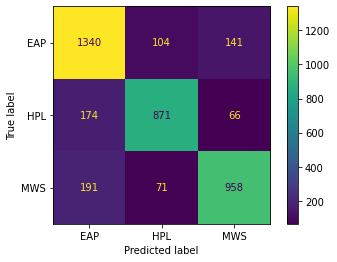

In [23]:
evaluate(y_test, y_pred_svm)

BertClassifier

Using logits as encoding doesn't work (as expected)

In [43]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

In [58]:
svm.fit(x_train_classification, y_train)

y_pred_svm = svm.predict(x_test_classification)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy of the model: 0.452


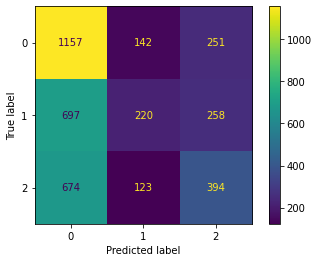

In [61]:
evaluate(y_test, y_pred_svm)

Bert Last

In [4]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

In [5]:
svm.fit(x_train_last, y_train)

y_pred_svm = svm.predict(x_test_last)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy of the model: 0.800
F1-score of the model: 0.800
Precision score of Model: 0.800
Recall score of Model: 0.800


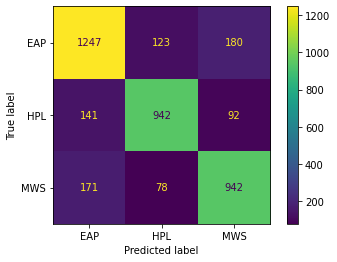

In [12]:
evaluate(y_test, y_pred_svm)

## Logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [25]:
lr.fit(x_train, y_train) 
y_pred_lr = lr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy of the model: 0.806
F1-score of the model: 0.806
Precision score of Model: 0.806
Recall score of Model: 0.806


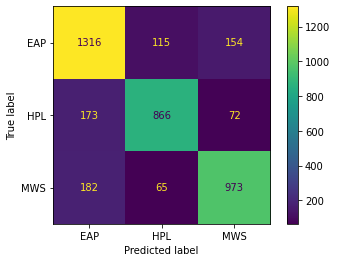

In [26]:
evaluate(y_test, y_pred_lr)

Bert Last

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [14]:
lr.fit(x_train_last, y_train) 
y_pred_lr = lr.predict(x_test_last)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy of the model: 0.799
F1-score of the model: 0.799
Precision score of Model: 0.800
Recall score of Model: 0.799


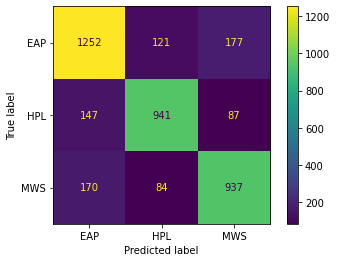

In [15]:
evaluate(y_test, y_pred_lr)

## XGBoost

In [27]:
xgb_classifier2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 objective='multi:softmax',
 nthread=4,
 num_class = 3)

In [28]:
xgb_classifier2.fit(x_train, y_train)
xgb_pred2 = xgb_classifier2.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the model: 0.792
F1-score of the model: 0.792
Precision score of Model: 0.793
Recall score of Model: 0.792


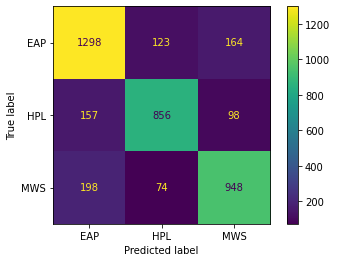

In [29]:
evaluate(y_test, xgb_pred2)

BertClassifier

Using logits as encoding doesn't work (as expected)

In [62]:
xgb_classifier2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 objective='multi:softmax',
 nthread=4,
 num_class = 3)

In [63]:
xgb_classifier2.fit(x_train_classification, y_train)
xgb_pred2 = xgb_classifier2.predict(x_test_classification)

Accuracy of the model: 0.454


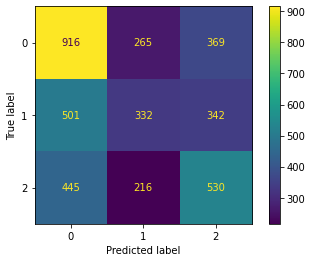

In [64]:
evaluate(y_test, xgb_pred2)

Bert Last

In [17]:
xgb_classifier2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 objective='multi:softmax',
 nthread=4,
 num_class = 3)

In [18]:
xgb_classifier2.fit(x_train, y_train)
xgb_pred2 = xgb_classifier2.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the model: 0.788
F1-score of the model: 0.788
Precision score of Model: 0.789
Recall score of Model: 0.788


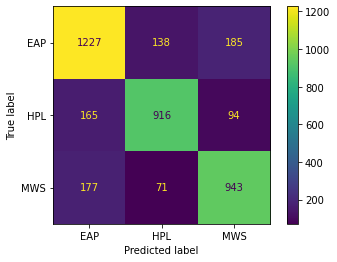

In [19]:
evaluate(y_test, xgb_pred2)